# In Depth: Principal Component Analysis
在本节中，我们将探讨无监督算法中最广泛使用的一种算法——主成分分析(PCA)。PCA本质上是一种降维算法，但它也可以作为可视化、噪声滤波、特征提取和特征工程等方面的工具。

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Introducing Principal Component Analysis

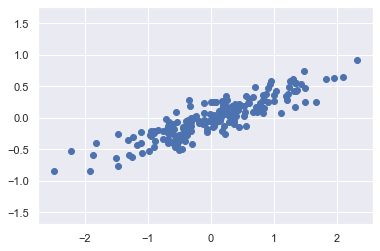

In [3]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

无监督学习问题试图了解x和y值之间的“关系”。
在主成分分析中，通过查找数据中的主轴列表并使用这些轴来描述数据集来量化这种关系。使用Scikit-Learn的PCA估计器，我们可以计算如下:

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [5]:
print(pca.components_)#using the "components" to define the direction of the vector,

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [6]:
print(pca.explained_variance_)#the "explained variance" to define the squared-length of the vector

[0.7625315 0.0184779]


为了理解这些数字的含义，让我们将它们可视化为输入数据上的向量，使用“分量”来定义向量的方向，使用“解释的方差”来定义向量的平方长度

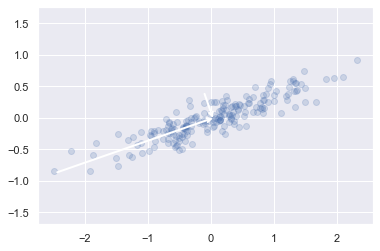

In [7]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v0,v1,arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

这些向量表示数据的主轴，而向量的长度表示该轴在描述数据分布时的“重要性”——更准确地说，它是数据在投射到该轴时的方差的度量。 每个数据点在主轴上的投影是数据的“主成分”。
这种从数据轴到主轴的转换是一种仿射转换，这基本上意味着它是由平移、旋转和均匀缩放组成的。 虽然这种寻找主成分的算法似乎只是一个数学上的好奇心，但它在机器学习和数据探索领域有着非常深远的应用。

# PCA as dimensionality reduction
使用PCA进行降维包括将一个或多个最小的主成分归零，从而得到一个保持最大数据方差的数据的低维投影。

In [8]:
#二维降成一维
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


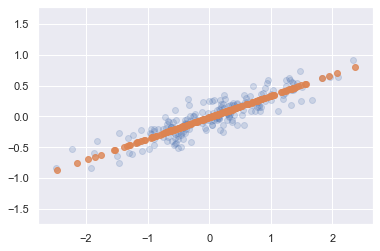

In [9]:
#降维到一维后的数据，转换回二维，与原始数据比较
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

# PCA for visualization: Hand-written digits

In [10]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [11]:
pca = PCA(n_components=2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


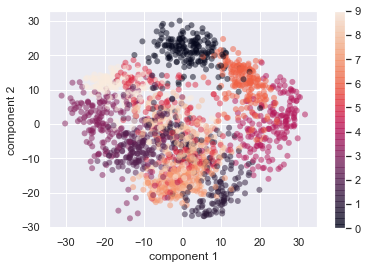

In [12]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

# What do the components mean?

# Choosing the number of components
在实践中使用PCA的一个重要部分是能够估计需要多少组件来描述数据。 这可以通过查看累积解释的方差比作为组件数量的函数来确定:

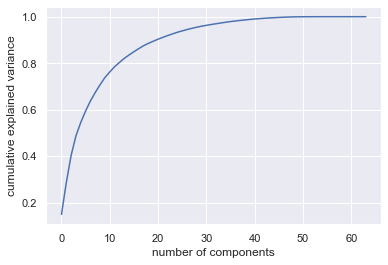

In [13]:
#如何选择合适数量的成分
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

此曲线量化了第一个$N$组件中包含的总64维方差的大小。例如，我们看到前10个分量包含大约75%的方差，而您需要大约50个分量来描述接近100%的方差。这里我们看到，我们的二维投影丢失了很多信息(通过解释的方差测量)，我们需要大约20个组件来保留90%的方差。查看高维数据集的此图可以帮助您了解多个观察中存在的冗余级别。

# PCA as Noise Filtering

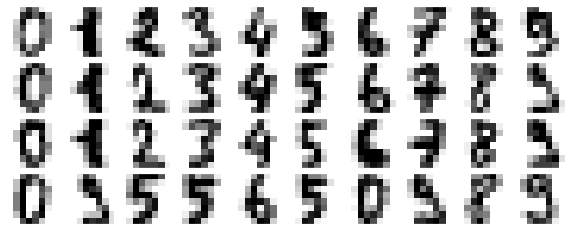

In [14]:
#无噪声数据
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

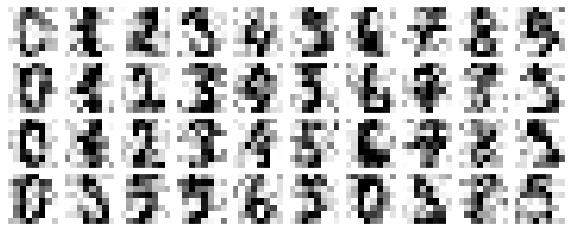

In [15]:
#有噪声数据
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

In [16]:
#这里50%的方差等于12个主成分。现在我们计算这些分量，然后用变换的逆来重建过滤后的数字:
pca = PCA(0.50,svd_solver = 'full').fit(noisy)
# n_components可以是 int, float, None or string
# None会保留所有的组件，float时也要保证svd_solver == 'full'，此时选择组件的数量，使需要解释的差异量大于n_components指定的百分比。
pca.n_components_

12

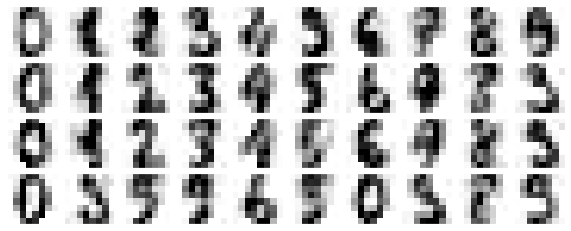

In [16]:
#去除噪声影响后的数据
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

# Example: Eigenfaces

In [17]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


In [18]:
from sklearn.decomposition import PCA as RandomizedPCA
pca = RandomizedPCA(150)
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

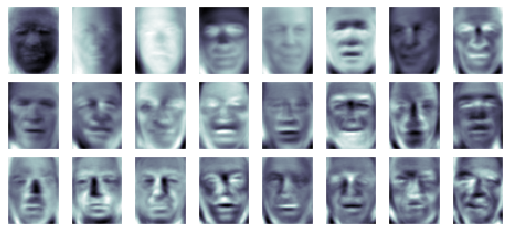

In [19]:
#在这种情况下，将与前几个主成分(这些成分在技术上被称为“特征向量”，所以这些类型的图像通常被称为“特征脸”)相关的图像可视化会很有趣
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

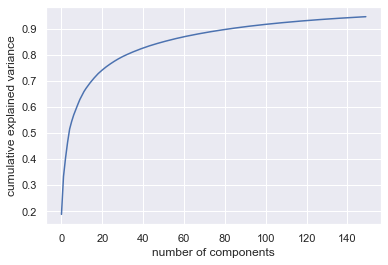

In [20]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

We see that these 150 components account for just over 90% of the variance.
That would lead us to believe that using these 150 components, we would recover most of the essential characteristics of the data.
To make this more concrete, we can compare the input images with the images reconstructed from these 150 components:

In [21]:
# Compute the components and projected faces
pca = RandomizedPCA(150).fit(faces.data)
print(faces.data.shape)
components = pca.transform(faces.data)
print(components.shape)
projected = pca.inverse_transform(components)
print(projected.shape)

(1348, 2914)
(1348, 150)
(1348, 2914)


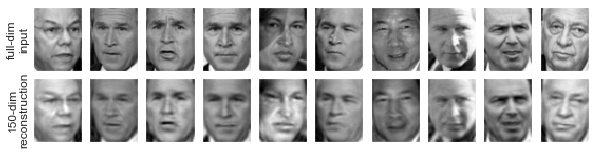

In [22]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

这里的第一行显示的是输入图像，而下面一行显示的是从大约3000个初始特征中的150个特征重建出来的图像。这种可视化解释了为什么使用PCA进行特征选择会非常成功: 尽管它降低数据的维数近20倍, 但投影的图像包含足够的信息，人眼能够清楚的分辨出来。这意味着我们的分类算法只需要在150维的数据上进行训练，而不是在3000维的数据上进行训练，这取决于我们选择的特定算法，这会导致更有效的分类。

在本节中，我们讨论了主成分分析在降维、高维数据可视化、噪声滤波和高维数据中特征选择方面的应用。由于PCA的通用性和可解释性，它已被证明在各种上下文和学科中都是有效的。给出任何高维数据集,我倾向于从PCA为了想象之间的关系点(我们的数字),了解主要方差数据(如我们eigenfaces),和理解的内在维度(通过绘制解释方差比率)。当然，PCA并不是对所有高维数据集都有用，但是它提供了一种简单而有效的方法来洞察高维数据。
主成分分析的主要缺点是，它往往受到数据中的异常值的严重影响。由于这个原因，已经开发了许多健壮的PCA变体，其中许多变体的作用是迭代地丢弃初始组件描述得很差的数据点。